# Traffic Flow Simulator

In [1]:
from utils import Agent, Road, Trpf, read_config
from itertools import repeat
from altair import Chart
import numpy as np
import pandas as pd

## Functions

In [2]:
def get_route_choices(agents, route_count):
    choices = list(map(lambda agent: agent.choose_route(), agents))
    route_traveller_counts = np.bincount(choices, minlength = route_count)[:, np.newaxis]
    return choices, route_traveller_counts

def get_route_costs(roads, choices, route_traveller_counts):
    road_traveller_counts = np.array(route_to_road * route_traveller_counts)
    list(map(lambda count, road: road.add_travellers(count), road_traveller_counts[:,0], roads))
    road_costs = np.array(list(map(lambda road: road.report_cost(), roads)))[:, np.newaxis]
    route_costs = np.array(road_to_route * road_costs)
    return route_costs

def give_costs(agents, choices, route_costs):    
    list(map(lambda agent, choice: agent.recieve_travel_cost(route_costs[choice,0]), agents, choices))
    
def get_reports(agents, trpf, choices, excess_traveller_counts):
    reports = list(map(lambda agent, choice, excess: agent.report_congestion(excess[choice,0]),\
        agents, choices, repeat(excess_traveller_counts)))
    list(map(lambda route, report: trpf.recieve_report(route, report), choices, reports))
    
def give_trpfs(trpf_agents, route_trpfs):
    list(map(lambda agent, trpf: agent.recieve_trpf(trpf), trpf_agents, repeat(route_trpfs)))

## Read the configuration

In [3]:
simulation_folder = '/home/ihsan/Research/TrafficFlow/simulations/5/'
traffic_file = simulation_folder + 'traffic.properties'
roadnet_file = simulation_folder + 'roadnet.csv'

config = read_config(traffic_file, roadnet_file)

tresholds = config['tresholds']
weights = config['weights']
trpf_use_percent = config['trpf_use_percent']
t = config['t']
agent_count = config['agent_count']
change_percent = config['change_percent']
routes = config['routes']
route_opts = np.array(config['route_opts'])[:, np.newaxis]
round_count = 1000 #config['round_count']
road_params = config['road_params']

## Initialize the simulation

In [4]:
route_count = len(routes)

trpf = Trpf(route_count, round_count, t)

roads = []
road_inds = {}
for i, params in enumerate(road_params.itertuples(index=False)):
    road = Road(*params)
    roads.append(road)
    road_name = params[0] + params[1] # Node 1 + Node 2
    road_inds[road_name] = i
    
agents = []
trpf_agents = []
for tag in range(agent_count):
    agent = Agent(tag, tresholds, weights, route_count, change_percent, trpf_use_percent)
    agents.append(agent)
    if agent.uses_trpf():
        trpf_agents.append(agent)
trpf_agents = trpf_agents

route_to_road = np.zeros((len(roads), len(routes)))
for i, route in enumerate(routes):
    for e in range(1, len(route)):
        road_name = route[e-1] + route[e]
        j = road_inds[road_name]
        route_to_road[j, i] = 1
route_to_road = np.matrix(route_to_road)
road_to_route = route_to_road.T 

data = pd.DataFrame(columns = ['Route', 'Count', 'Cost', 'Trpf', 'Round'])

print('Number of trpf users: {}, Number of routes: {}, Number of roads:{}'.format(len(trpf_agents),\
    route_count, len(roads)))

Number of trpf users: 186, Number of routes: 3, Number of roads:7


I can try addding a nice graph of the network, like the ones in the paper, here. We can also add other visualizations that describe the system we are simulating.

## Simulation

In [5]:
while trpf.start_new_round():
    choices, route_traveller_counts = get_route_choices(agents, route_count)
    excess_traveller_counts = np.absolute(route_traveller_counts - route_opts)
    route_costs = get_route_costs(roads, choices, route_traveller_counts)
    give_costs(agents, choices, route_costs)
    get_reports(agents, trpf, choices, excess_traveller_counts)
    route_trpfs = trpf.calculate_trpf()
    give_trpfs(trpf_agents, route_trpfs)
   
    # Save the choices
    for route in range(route_count):
        route_cost = route_costs[route,0]
        route_trpf = route_trpfs[route]
        route_traveller_count = route_traveller_counts[route,0]
        
        data.loc[data.shape[0]] = [route, route_traveller_count, route_cost, route_trpf, trpf.current_round]

## Visualizations

### Statistics

In [6]:
# Drop the first 200 rounds, Trpf and Round Columns
data['TotalCost'] = data.Count * data.Cost
data_by_routes = data.drop(['Round', 'Trpf'], axis=1).drop(np.arange(600)).groupby('Route')

means = data_by_routes.mean()
means.columns = ['CountMean', 'CostMean', 'TotalCostMean']

stds = data_by_routes.std()
stds.columns = ['CountStd', 'CostStd', 'TotalCostStd']

report = pd.concat([means, stds], axis=1)
report = report[['CountMean', 'CountStd', 'CostMean', 'CostStd', 'TotalCostMean', 'TotalCostStd']]

report

,CountMean,CountStd,CostMean,CostStd,TotalCostMean,TotalCostStd
Route,,,,,,
0.0,11.7300,1.498301,50.00000,0.000000,586.500000,74.915054
1.0,65.7375,26.483869,58.82700,0.149830,3867.053125,1557.741841
2.0,122.5325,26.558956,51.08025,2.671799,6329.751375,1668.376655


### Agent Count per Route over Time

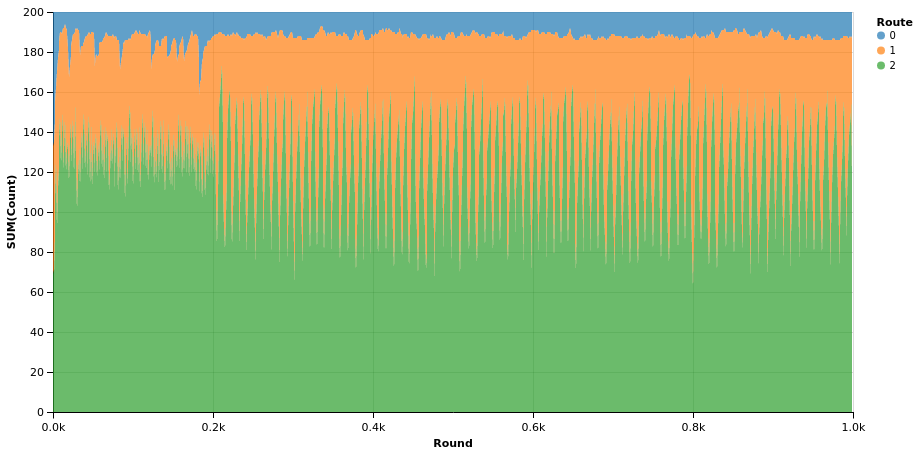

In [7]:
chart = Chart(data).mark_area().encode(x='Round:Q', y='sum(Count):Q', color='Route:N')
chart.configure_cell(height=400, width=800)

### Cost per Agent per Route over Time

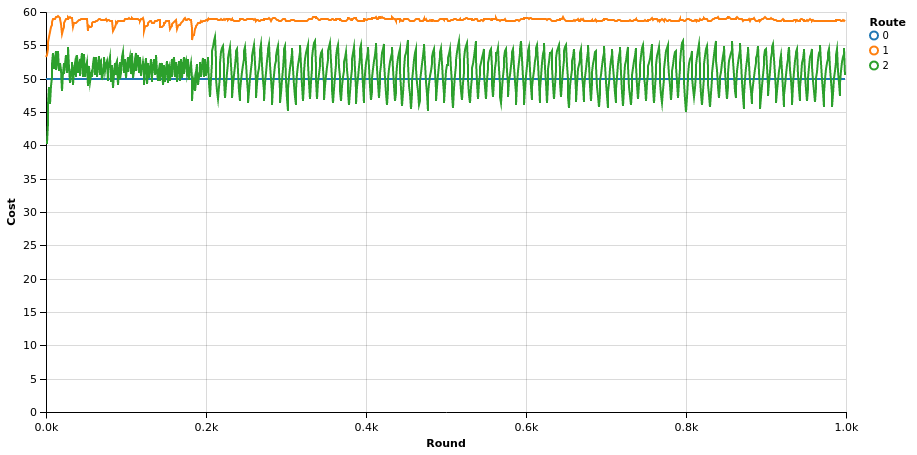

In [8]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='Cost:Q', color='Route:N')
chart.configure_cell(height=400, width=800)

### Total Cost over Time

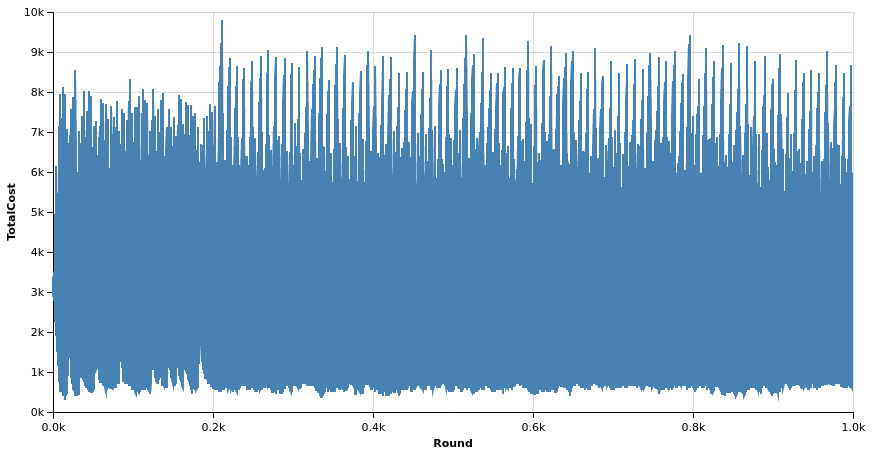

In [9]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='TotalCost:Q')
chart.configure_cell(height=400, width=800)

The current algorithm works much worse than I expected. Total cost is fluctuating wildly. The graph looks like an area graph but it was actually supposed to be a line graph... At the very least we should have seen a decrease in amplitude over time. 

I think we should be optimizing for the total cost of travel. The algorithm looks nowhere near converging to the SO.

### Trpf over Time

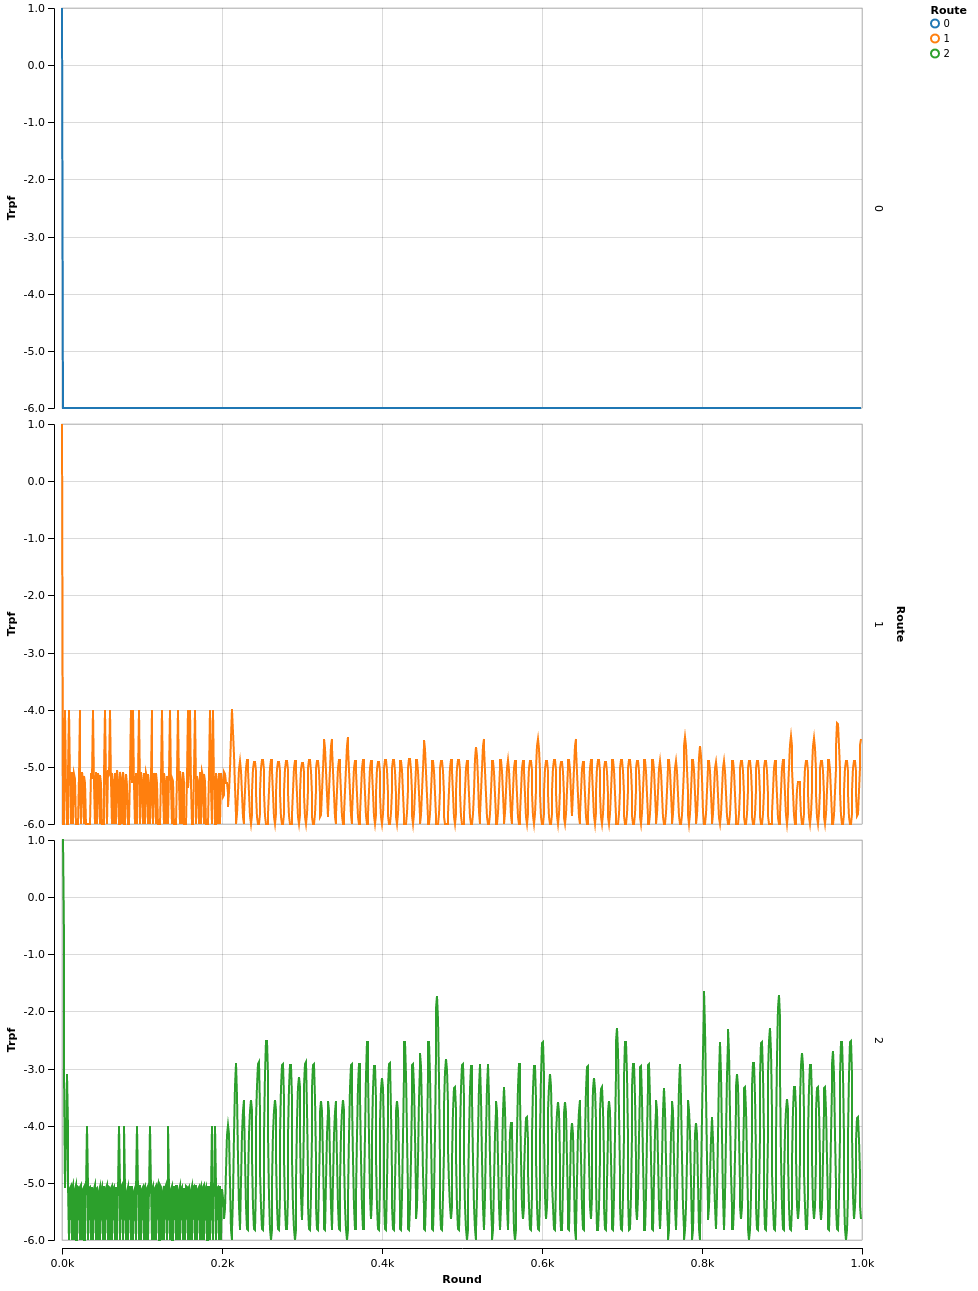

In [10]:
chart = Chart(data).mark_line().encode(x='Round:Q', y='Trpf:Q', color='Route:N', row='Route:N')
chart.configure_cell(height=400, width=800)

I applied the moving average at round 200. Slower response decreased the oscillation frequency and increased the amplitude. 

We can try enveloping the trpf magnitude to prevent it from overreacting or implementing sub-rounds for faster response. 